## Magnet optimization

In [2]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import cvxpy as cp

In [8]:
Br = 1.31 # (T) Residual flux density for N42
mu_0 = 4 * np.pi * 10**-7 # (H/m) Permeability of free space
l = 3e-3 # (m) Length of cube magnet
Volume = l ** 3 # (m^3)
moment = Br * Volume / mu_0 # (A m^2)

In [9]:
target = np.array([0, 0, 0.4]) # target position is at 40 cm above the origin
workspace_length = 0.2 # workspace is a cube of 20 cm side length
mt= np.array([moment, 0, 0])

In [10]:
# Magnet properties
Br = 1.31 # (T) Residual flux density for N42
mu_0 = 4 * np.pi * 10**-7 # (H/m) Permeability of free space
l = 1.5875e-3 # (m) Length of cube magnet
Volume = l ** 3 # (m^3)
moment = Br * Volume / mu_0 # (A m^2)

In [11]:
# return the magnetic field generated by a magnet at position p and orientation r
def generate_random_pose() -> tuple[np.ndarray, np.ndarray]:
    # generate a random pose
    r = R.random()
    p = np.random.rand(3) * workspace_length
    return p, r.as_matrix()

In [12]:
def Jb(r_i: np.ndarray, dm_i: np.ndarray):
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * np.dot((3 * r_i_hat*np.transpose(r_i_hat) - np.eye(3)), dm_i)

def Jf(r_i: np.array, dm_i: np.ndarray):
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.dot(dm_i, r_i_hat.transpose()) + 
      np.dot(r_i_hat, dm_i.transpose()) - 
      np.dot(np.dot(r_i_hat.transpose(), dm_i), (5 * r_i_hat*np.transpose(r_i_hat) - np.eye(3)))
      ,mt)

In [14]:
theta = 0.5
p = [np.cos(theta), np.sin(theta), 0]
r = R.random()
p1 = r.as_matrix().dot(p)
p_r, r_r = generate_random_pose()
print(Jb(p_r, p1))
print(Jf(p_r, p1))
np.concatenate([Jb(p_r, p1), Jf(p_r, p1)])

[-3.55192419e-08 -4.51887104e-08 -3.12630555e-10]
[-8.13110680e-09 -5.42072755e-09 -5.42072755e-09]


array([-3.55192419e-08, -4.51887104e-08, -3.12630555e-10, -8.13110680e-09,
       -5.42072755e-09, -5.42072755e-09])

In [205]:
J = np.array([1, 2, 3, 4])
print(J)
print(np.outer(J, J))

[1 2 3 4]
[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]
 [ 4  8 12 16]]


In [15]:
m = 50
K = 6 # Selection budget
d = 4
n = d ** K

In [16]:
# Generating all combinations of angles
angles = np.array(np.meshgrid(*[np.linspace(0, np.pi, d) for i in range(K)])).T.reshape(-1, K)

In [17]:
S = [generate_random_pose() for i in range(m)]

In [52]:
# Initizaling A
A = np.zeros((n, K, m, K, K))

for t, theta in enumerate(angles):
  for i in range(K):
    for j, (p, r) in enumerate(S):
      magnetization = r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
      J = np.concatenate([Jb(p, magnetization), Jf(p, magnetization)])
      A[t, i, j, :, :] = np.outer(J, J)
    


In [55]:
def A_operator(X):
  sum = np.zeros((K, K))
  for t in range(n):
    for i in range(K):
      for j in range(m):
        sum += X[i][j] * A[t, i, j]
  return sum

In [62]:
X = cp.Variable((K, m))
t = cp.Variable(1)

obj = cp.Maximize(t)
cons1 = X >= 0.0
cons2 = X <= 1.0
cons3 = t <= cp.atoms.lambda_min(A_operator(X)).value()
cons4 = cp.sum(X) == K
cons5 = cp.sum(X, axis=1) <= 1
cons6 = cp.sum(X, axis=0) <= 1
prob = cp.Problem(obj, [cons1, cons2, cons3, cons4, cons5, cons6])

RuntimeError: 
You're trying to mutate a CVXPY expression inplace. This is prone to errors or
code that doesn't behave as expected. Consider alternatives. For example, replace
    x += 1
with
    x = x + 1


## TESTING STUFF BELOW

In [ ]:
x = cp.Variable(1)
t = cp.Variable(1)

obj = cp.Maximize(t)
cons1 = x >= 0.0
cons2 = x <= 10.0
cons3 = t <= -x
prob = cp.Problem(obj, [cons1, cons2, cons3])
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [24]:
test = cp.Constant(np.array([[1, 2, 3], [4, 5, 6]]))

In [49]:
bl = cp.Constant(np.array([[1, 0, 1], [1, 0, 0]])) 
blsum = bl <= 1.0
blsum.value()

False

In [51]:
cp.sum(test, 0).value

array([5., 7., 9.])

In [164]:
theta = 0
p = [np.cos(theta), np.sin(theta), 0]

In [165]:
def are_points_too_close(self, ind):
    for i in range(0, self.n * 2, 2):
        for j in range(i+2, self.n * 2, 2):
            dis = np.sqrt((ind[i] - ind[j])**2 + (ind[i+1] - ind[j+1])**2)
            if dis < self.min_distance:
                return True
    return False

## Testing visualization stuff

In [166]:
r = R.random()
print(r.as_euler('ZYX', degrees=True))

[ 73.69410889  64.24066955 -63.12761221]


[array([ 0.        ,  0.        ,  0.        ,  0.12201837,  0.41711109,
       -0.90062748]), array([ 0.        ,  0.        ,  0.        , -0.65938314, -0.64415176,
       -0.38766272]), array([ 0.        ,  0.        ,  0.        , -0.74183919,  0.64116055,
        0.19643767])]


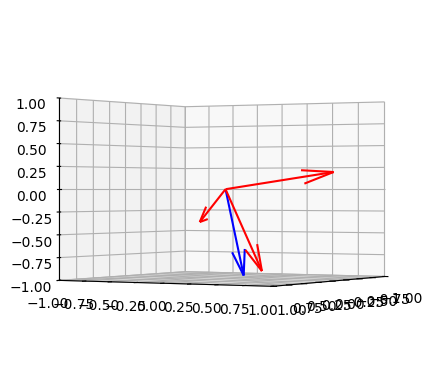

In [167]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# rotates around x, y

theta = 0.5
p = [np.cos(theta), np.sin(theta), 0]
xyz = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
# r = R.from_euler('ZYX', [45, 0, 90], degrees=True)
p1 = r.as_matrix().dot(p)
p2s = [np.concatenate(([0, 0, 0], r.as_matrix().dot(x))) for x in xyz]
print(p2s)
# soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
# p2s.append([0, 0, 0, p1[0], p1[1], p1[2]])
soa = np.array(p2s)

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color='r')
soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
X, Y, Z, U, V, W = zip(*soa)
ax.quiver(X, Y, Z, U, V, W, color='b')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(00, 30) 
plt.show()